# Optimisation de la Supply Chain

### 1. Introduction
Dans ce projet, nous cherchons à **optimiser la supply chain** grâce à l’analyse des données disponibles.  
Les objectifs sont :

- Comprendre la capacité d’inventaire en aval afin d’optimiser le flux des produits.
- Planifier les itinéraires logistiques pour accélérer la livraison.
- Partager les données logistiques pour améliorer la visibilité.

Le **Big Data** permet d’accélérer les livraisons, réduire les coûts et améliorer l’efficacité.  


### 2. Import des bibliothèques & chargement des données

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = "../data/raw/supply_chain_data.csv"
df = pd.read_csv(path)


print("Colonnes disponibles:", df.columns.tolist())
df.head()

Colonnes disponibles: ['Product type', 'SKU', 'Price', 'Availability', 'Number of products sold', 'Revenue generated', 'Customer demographics', 'Stock levels', 'Lead times', 'Order quantities', 'Shipping times', 'Shipping carriers', 'Shipping costs', 'Supplier name', 'Location', 'Lead time', 'Production volumes', 'Manufacturing lead time', 'Manufacturing costs', 'Inspection results', 'Defect rates', 'Transportation modes', 'Routes', 'Costs']


,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632


In [60]:
df['Product type'].value_counts()

Product type
skincare     40
haircare     34
cosmetics    26
Name: count, dtype: int64

### 3. Analyse de la capacité d’inventaire

In [61]:
inventory = df.groupby("Product type").agg({
    "Stock levels": "sum",
    "Number of products sold": "sum",
    "Lead time": "mean"
})

In [62]:
inventory["Turnover_rate"] = inventory["Number of products sold"] / inventory["Stock levels"].replace(0, np.nan)

In [63]:
inventory["DOI"] = inventory["Stock levels"] / (inventory["Number of products sold"] / 30).replace(0, np.nan)

In [64]:
inventory = inventory.sort_values("Number of products sold", ascending=False)
inventory["cumulative_sales"] = inventory["Number of products sold"].cumsum()
total_sales = inventory["Number of products sold"].sum()
inventory["cumulative_share"] = inventory["cumulative_sales"] / total_sales

In [65]:
print("\nInventaire avec KPI :")
print(inventory.head(10).to_string())


Inventaire avec KPI :
              Stock levels  Number of products sold  Lead time  Turnover_rate       DOI  cumulative_sales  cumulative_share
Product type                                                                                                               
skincare              1608                    20731  18.000000      12.892413  2.326950             20731          0.449706
haircare              1644                    13611  18.705882       8.279197  3.623540             34342          0.744962
cosmetics             1525                    11757  13.538462       7.709508  3.891299             46099          1.000000


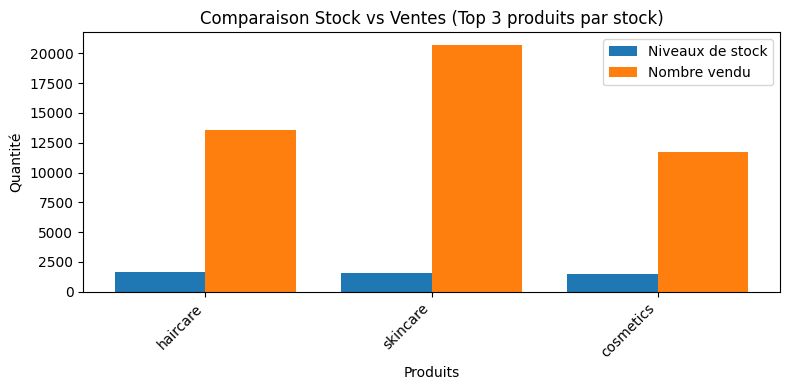

In [66]:
inventory_sorted_by_stock = inventory.sort_values("Stock levels", ascending=False)
top_n = 3
plot_df = inventory_sorted_by_stock.head(top_n)

plt.figure(figsize=(8,4))
x = np.arange(len(plot_df.index))
width = 0.4

plt.bar(x - width/2, plot_df["Stock levels"], width=width, label="Niveaux de stock", color="#1f77b4")
plt.bar(x + width/2, plot_df["Number of products sold"], width=width, label="Nombre vendu", color="#ff7f0e")

plt.xticks(x, plot_df.index, rotation=45, ha="right")
plt.ylabel("Quantité")
plt.xlabel("Produits")
plt.title(f"Comparaison Stock vs Ventes (Top {top_n} produits par stock)")
plt.legend()
plt.tight_layout()
plt.show()


Stock et ventes par type de produit : On a regroupé les données par type de produit pour calculer les niveaux de stock totaux et les ventes totales. 

Cela permet de voir quels produits occupent le plus d’espace dans l’inventaire et lesquels se vendent le plus.

In [67]:
import matplotlib.pyplot as plt

# Trier l'inventaire par taux de rotation
inventory_sorted_by_turnover = inventory.sort_values("Turnover_rate")

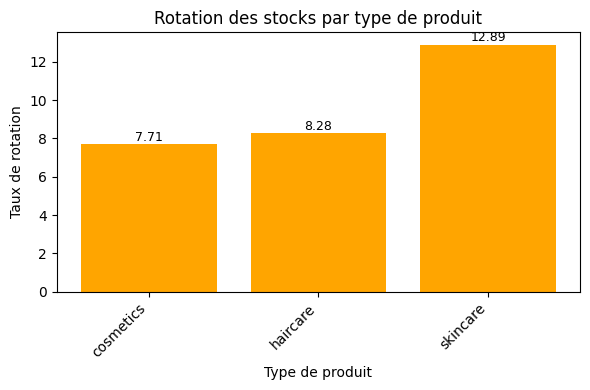

In [68]:
plt.figure(figsize=(6,4))

# Barres avec couleur
bars = plt.bar(
    inventory_sorted_by_turnover.index, 
    inventory_sorted_by_turnover["Turnover_rate"], 
    color="orange"
)

# Ajout des valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        height + 0.01,  # léger décalage au-dessus de la barre
        f"{height:.2f}", 
        ha="center", 
        va="bottom",
        fontsize=9
    )

# Titres et axes
plt.title("Rotation des stocks par type de produit")
plt.xlabel("Type de produit")
plt.ylabel("Taux de rotation")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


Rotation des stocks : Le Turnover_rate montre à quelle vitesse les produits se vendent par rapport au stock disponible.

Une rotation élevée signifie que le produit se vend rapidement et qu’il faut reconstituer le stock plus souvent.

In [69]:
heatmap_df = inventory[["Stock levels", "DOI", "Turnover_rate"]]

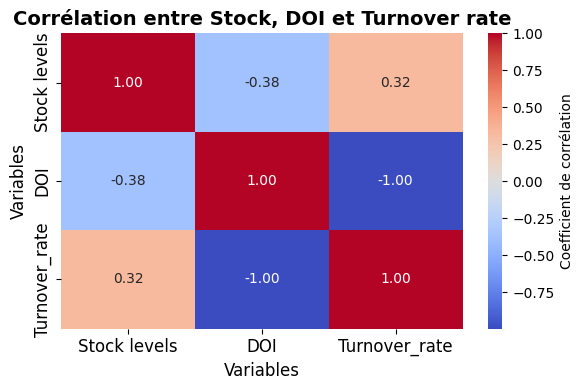

In [70]:
plt.figure(figsize=(6,4))

sns.heatmap(
    heatmap_df.corr(), 
    annot=True,                
    fmt=".2f",                
    cmap="coolwarm", 
    center=0,
    cbar_kws={'label': 'Coefficient de corrélation'} 
)


plt.title("Corrélation entre Stock, DOI et Turnover rate", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Variables", fontsize=12)

plt.tight_layout() 
plt.show()


Une corrélation positive entre Stock levels et DOI signifie que plus le stock est élevé, plus les produits restent longtemps en inventaire.

Une corrélation négative entre DOI et Turnover_rate indique qu’un produit qui reste longtemps en stock a tendance à se vendre plus lentement

In [71]:
def abc_classification(x):
    if x <= 0.8:
        return "A"   
    elif x <= 0.95:
        return "B"   
    else:
        return "C" 

In [72]:
inventory["ABC"] = inventory["cumulative_share"].apply(abc_classification)

In [73]:
print("\nDétail des ventes avec classification ABC :")
print(inventory.to_string())


Détail des ventes avec classification ABC :
              Stock levels  Number of products sold  Lead time  Turnover_rate       DOI  cumulative_sales  cumulative_share ABC
Product type                                                                                                                   
skincare              1608                    20731  18.000000      12.892413  2.326950             20731          0.449706   A
haircare              1644                    13611  18.705882       8.279197  3.623540             34342          0.744962   A
cosmetics             1525                    11757  13.538462       7.709508  3.891299             46099          1.000000   C


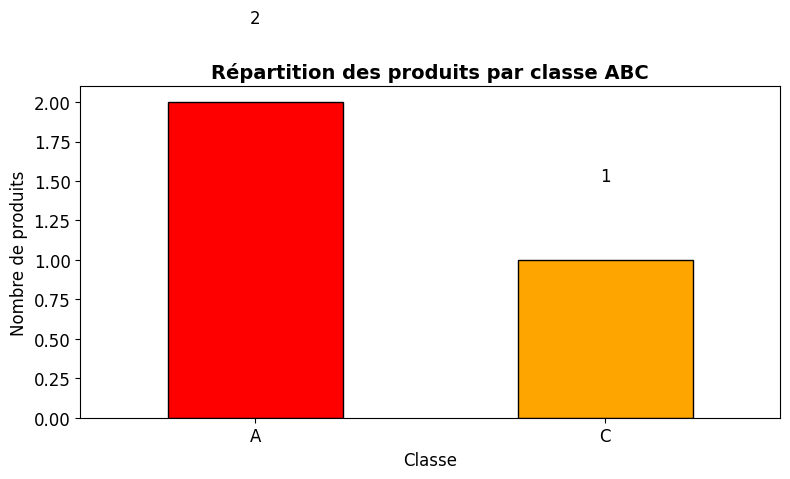

In [74]:
plt.figure(figsize=(8,5))

counts = inventory["ABC"].value_counts().sort_index()  
colors = ["red", "orange", "green"] 
counts.plot(kind="bar", color=colors, edgecolor='black')

plt.title("Répartition des produits par classe ABC", fontsize=14, fontweight='bold')
plt.xlabel("Classe", fontsize=12)
plt.ylabel("Nombre de produits", fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

for i, v in enumerate(counts):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()


Analyse ABC : On classe les produits selon leur contribution aux ventes. 

Les produits A représentent généralement les plus vendus ou produits stratégiques. 

B produits intermédiaires, et C les moins vendus. 

Cela aide à prioriser la gestion de l’inventaire.

### 4. Planification logistique

In [75]:
inventory = df.groupby("Product type").agg({
    "Stock levels": "sum",
    "Number of products sold": "sum",
    "Lead time": "mean",
    "Order quantities": "sum",
    "Shipping times": "mean"
})

In [76]:
inventory["Turnover_rate"] = inventory["Number of products sold"] / inventory["Stock levels"].replace(0, pd.NA)

In [77]:
inventory = inventory.sort_values("Number of products sold", ascending=False)
inventory["cumulative_sales"] = inventory["Number of products sold"].cumsum()
total_sales = inventory["Number of products sold"].sum()
inventory["cumulative_share"] = inventory["cumulative_sales"] / total_sales


In [78]:
def abc_classification(x):
    if x <= 0.8: return "A"   # produits stratégiques
    elif x <= 0.95: return "B" # produits intermédiaires
    else: return "C"          # produits peu vendus

In [79]:
inventory["ABC"] = inventory["cumulative_share"].apply(abc_classification)

In [80]:
delivery_priority = inventory.sort_values(["ABC", "Lead time"], ascending=[True, True])

In [81]:
print("=== Priorité de livraison par produit ===")
print(delivery_priority[["Stock levels","Number of products sold","Lead time","Order quantities","ABC"]].to_string())

=== Priorité de livraison par produit ===
              Stock levels  Number of products sold  Lead time  Order quantities ABC
Product type                                                                        
skincare              1608                    20731  18.000000              2099   A
haircare              1644                    13611  18.705882              1480   A
cosmetics             1525                    11757  13.538462              1343   C


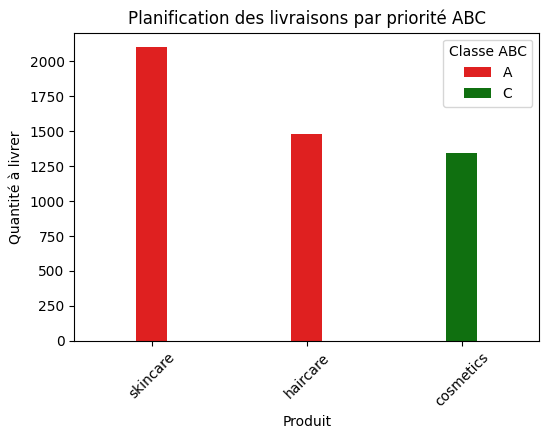

In [82]:
plt.figure(figsize=(6,4))
sns.barplot(
    x=delivery_priority.index,
    y=delivery_priority["Order quantities"],
    hue=delivery_priority["ABC"],
    dodge=False,
    palette={"A":"red","B":"orange","C":"green"},
    width=.2
)
plt.xticks(rotation=45)
plt.ylabel("Quantité à livrer")
plt.xlabel("Produit")
plt.title("Planification des livraisons par priorité ABC")
plt.legend(title="Classe ABC")
plt.show()

Les produits sont classés selon leur contribution aux ventes :

A : produits stratégiques, priorité haute

B : produits intermédiaires (n'existe pas dans cette donnée)

C : produits peu vendus

Cette classification aide à prioriser les livraisons pour optimiser les ressources logistiques.

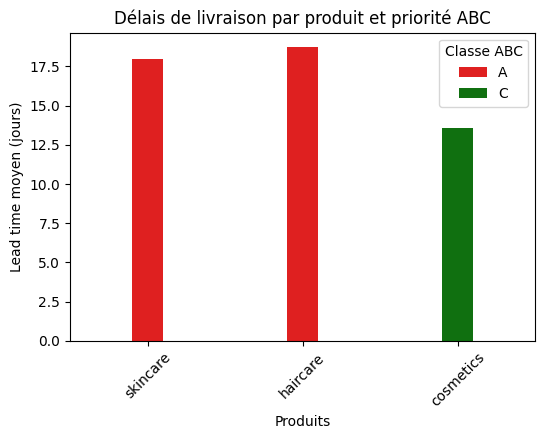

In [83]:
plt.figure(figsize=(6,4))
sns.barplot(
    x=delivery_priority.index,
    y=delivery_priority["Lead time"],
    hue=delivery_priority["ABC"],
    dodge=False,
    palette={"A":"red","B":"orange","C":"green"},
    width=.2
)
plt.xticks(rotation=45)
plt.ylabel("Lead time moyen (jours)")
plt.xlabel("Produits")
plt.title("Délais de livraison par produit et priorité ABC")
plt.legend(title="Classe ABC")
plt.show()


Priorisation des livraisons

Les produits de classe A sont livrés en premier, suivis des classes B et C.

Au sein de chaque classe, on considère le lead time moyen pour accélérer la livraison des produits les plus urgents.

In [84]:
transport = df.groupby("Transportation modes").agg({
    "Shipping times": "mean",
    "Shipping costs": "mean"
})

In [85]:
print("Performance par mode de transport")
print(transport)

Performance par mode de transport
                      Shipping times  Shipping costs
Transportation modes                                
Air                         5.115385        6.017839
Rail                        6.571429        5.469098
Road                        4.724138        5.542115
Sea                         7.117647        4.970294


In [86]:
routes = df.groupby("Routes")["Shipping times"].mean().sort_values()
print("\n routes les plus rapides:")
routes.head()


 routes les plus rapides:


Routes
Route C    5.250000
Route B    5.702703
Route A    6.023256
Name: Shipping times, dtype: float64

In [87]:
route_prior = df.groupby("Routes")["Shipping times"].agg(["mean", "count"])
route_prior["priority_score"] = route_prior["mean"] * route_prior["count"]
route_prior.sort_values("priority_score", ascending=False).head()

,mean,count,priority_score
Routes,,,
Route A,6.023256,43,259.0
Route B,5.702703,37,211.0
Route C,5.250000,20,105.0


L’analyse des modes de transport met en évidence le compromis entre rapidité et coût, ce qui permet d’adapter le choix selon la priorité des produits (ABC).

Les routes rapides doivent être privilégiées pour les produits stratégiques, 

tandis que les routes lentes mais fréquemment utilisées sont à optimiser en priorité.

Cette approche améliore à la fois l’efficacité logistique et la réactivité de la supply chain.

In [88]:
transport = df.groupby("Transportation modes").agg({
    "Shipping times": "mean",
    "Shipping costs": "mean"
}).reset_index()


In [89]:
route_stats = df.groupby("Routes").agg({
    "Shipping times": "mean",
    "Number of products sold": "sum"  # fréquence approximative
}).rename(columns={"Number of products sold": "count"}).reset_index()


In [90]:
route_stats["priority_score"] = route_stats["Shipping times"] * route_stats["count"]

In [91]:
delivery_plan = inventory.reset_index()[["Product type","ABC","Lead time","Order quantities"]]

In [92]:
fastest_routes = route_stats.sort_values("Shipping times").groupby("Routes").first().reset_index()

In [93]:
best_route = route_stats.sort_values("Shipping times").iloc[0]["Routes"]

In [94]:
delivery_plan["Recommended Route"] = best_route

In [95]:
delivery_plan["ABC_rank"] = delivery_plan["ABC"].map({"A":1,"B":2,"C":3})
delivery_plan = delivery_plan.sort_values(["ABC_rank","Lead time"], ascending=[True,True]).drop(columns="ABC_rank")

In [96]:
print("=== Plan de livraison optimisé ===")
print(delivery_plan)


=== Plan de livraison optimisé ===
  Product type ABC  Lead time  Order quantities Recommended Route
0     skincare   A  18.000000              2099           Route C
1     haircare   A  18.705882              1480           Route C
2    cosmetics   C  13.538462              1343           Route C


Les produits sont classés par importance (ABC) et par lead time, ce qui permet de livrer d’abord les articles stratégiques (classe A) et urgents.

On associe ensuite les produits à la route la plus rapide, afin de réduire les délais de transport et d’accélérer la disponibilité.

Le plan de livraison ainsi construit combine priorisation produit et optimisation des itinéraires, garantissant une supply chain plus efficace et réactive.

In [97]:
delivery_plan.rename(columns={"ABC": "Product Priority"}, inplace=True)

In [98]:
abc_info = delivery_plan[["Product type", "Product Priority"]]
df_abc = df.merge(abc_info, on="Product type", how="left")

In [99]:
df_abc["ABC_rank"] = df_abc["Product Priority"].map({"A": 0, "B": 1, "C": 2})

In [100]:
df_sorted = df_abc.sort_values(
    by=["ABC_rank", "Lead time", "Stock levels"], 
    ascending=[True, True, False]
).drop('ABC_rank', axis=1)

In [101]:
print("=== Plan de livraison regroupé par classe ABC ===")
print(df_sorted.head(10).to_string())

=== Plan de livraison regroupé par classe ABC ===
   Product type    SKU      Price  Availability  Number of products sold  Revenue generated Customer demographics  Stock levels  Lead times  Order quantities  Shipping times Shipping carriers  Shipping costs Supplier name   Location  Lead time  Production volumes  Manufacturing lead time  Manufacturing costs Inspection results  Defect rates Transportation modes   Routes       Costs Product Priority
53     skincare  SKU53  30.341471            93                      242        8232.334829                  Male            96          25                54               3         Carrier B        1.013487    Supplier 1      Delhi          1                 631                       17            83.344059            Pending      1.410348                  Air  Route B  750.737841                A
74     haircare  SKU74   3.170011            64                      904        5709.945296                Female            41           6       


### 5. Partage & visibilité des données logistiques

In [102]:
cols = ["Supplier name", "Location", "Stock levels", "Lead time",
        "Shipping times", "Shipping carriers", "Shipping costs", "Product type", "Routes", "Product Priority"]


In [103]:
shared = df_sorted[cols].copy()

In [104]:
shared.to_csv("../data/processed/shared_logistics.csv", index=False)

shared.head()

,Supplier name,Location,Stock levels,Lead time,Shipping times,Shipping carriers,Shipping costs,Product type,Routes,Product Priority
53,Supplier 1,Delhi,96,1,3,Carrier B,1.013487,skincare,Route B,A
74,Supplier 4,Delhi,41,1,5,Carrier A,5.237655,haircare,Route A,A
43,Supplier 5,Mumbai,36,1,9,Carrier B,3.694021,haircare,Route A,A
68,Supplier 2,Bangalore,0,2,8,Carrier B,1.194252,haircare,Route A,A
12,Supplier 4,Kolkata,100,3,4,Carrier A,1.325274,haircare,Route B,A



### 6. Conclusion & recommandations

-  **Inventaire** : certains produits ont un turnover faible → risque de surstock, d’autres risquent rupture → prévoir un rééquilibrage.

-  **Logistique** : les modes de transport rapides doivent être privilégiés pour les produits critiques. Les routes avec un `priority_score` élevé sont à optimiser (renégociation fournisseurs, choix d’itinéraires alternatifs).

-  **Visibilité** : les KPI partagés permettent une meilleure collaboration entre fournisseurs, transporteurs et distributeurs.

 Étape suivante : mise en place d’un **dashboard (Power BI / Streamlit)** pour un suivi temps réel et intégration **Big Data (Spark, Kafka)** pour scalabilité.
